# DATA2001 Assignment 3
## Timeseries Data Analysis
### Jamie Katsamatsas s4674720
### 27/10/22
    
Questions
    
- Can include other datasets with US dollar values or US GDP values and merge them into the dataset
- Is MA5 or MA10 better for rolling averages??
- Are my drops in AIC and BIC small enough for arima??

#### Dataset Columns
- Date: Date of trades
- Open: Opening price, price of first trade of the day
- High: Highest price of all trades of the day
- Low: Lowest price of all trades of the day
- Close: Closing price, price of last trade before the end of day
- Volume: Total number of stocks traded during the day
- OpenInt: Open interest, the total number of outstanding derivative contracts, such as options or futures, that have not been settled for an asset at the end of day.

# Task 1 - Data Preparation
Read the dataset using the “pandas” library and set up the index in an appropriate way for timeseries analysis. Can you identify any useful side data or exogenous variables? If so, include them into your dataframe and handle/merge them in an appropriate way. Explain how you did it along with a justification for your choices.

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [344]:
amazon_data = pd.read_csv("amzn.us.csv")
amazon_data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0
...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0
5149,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0
5150,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0
5151,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0


In [345]:
# # Import Federal Funds Rate (Exogenous Variable)
# interest_rate = pd.read_csv("FEDFUNDS.csv")
# interest_rate

##### First we will clean the amazon stock price before merging the Interest Rate dataset in
Identify if any duplicated dates exist.

In [346]:
dup_rows = amazon_data['Date'].duplicated()
dup_rows.describe()

count      5153
unique        1
top       False
freq       5153
Name: Date, dtype: object

All 'Date' values are unique.

We will now set the Date as the index and check for missing business days in the dataset.

In [347]:
amazon_data = amazon_data.set_index('Date')
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

# Check if weekdays are missing from the dataset
pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B').difference(amazon_data.index)

DatetimeIndex(['1997-05-26', '1997-07-04', '1997-09-01', '1997-11-27',
               '1997-12-25', '1998-01-01', '1998-01-19', '1998-02-16',
               '1998-04-10', '1998-05-25',
               ...
               '2016-09-05', '2016-11-24', '2016-12-26', '2017-01-02',
               '2017-01-16', '2017-02-20', '2017-04-14', '2017-05-29',
               '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', length=193, freq=None)

There are 193 missing weekdays from the dataset between '1997-05-16' and '2017-11-10'. We will resample the dataset as buisness days = 'B' and fill them in my interpolating

In [348]:
# https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
amazon_data = amazon_data.resample('B').mean()
amazon_data = amazon_data.interpolate()
amazon_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0
...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0


In [349]:
# amazon_data.loc[['2017-04-12','2017-04-13','2017-04-14']]

In [350]:
# pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B').difference(amazon_data.index)
# len(pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B'))

# # bool_series = amazon_data['Date'].duplicated()
# # bool_series.describe()

In [351]:
# len(pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B'))
# pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B')

In [352]:
# Rename "Date" to "Datetime"
# amazon_data.rename(columns = {'Date': 'Datetime'}, inplace=True)


# set index to datetime
dates = pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B')
amazon_data.set_index(dates, inplace=True)

# # cast "Date" to "Datetime"
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

In [353]:
amazon_data.index
dates


DatetimeIndex(['1997-05-16', '1997-05-19', '1997-05-20', '1997-05-21',
               '1997-05-22', '1997-05-23', '1997-05-26', '1997-05-27',
               '1997-05-28', '1997-05-29',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', length=5346, freq='B')

In [354]:
amazon_data.head()

,Open,High,Low,Close,Volume,OpenInt
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0


### % Change Data
In stock trading Change and % Change are commonly tracked variables to see the relative change of the stock day to day. This value can be easily calculated once you know the stock close and open prices. Therefore I have decided to generate the change and % change values for this dataset

##### Reference

https://www.investopedia.com/terms/p/percentage-change.asp

In [355]:
amazon_data["Change"] = amazon_data["Close"] - amazon_data["Open"]
amazon_data["%Change"] = amazon_data["Change"] / amazon_data["Open"]
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778
...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815


Now the data contains a date that has a frequency of buisness days.

### Exogeneous Variable US Interest Rate
The exogenous variable for this dataset will be the US interest rate also known as the Federal Funds Rate. The interest rate has been included as it can affect stock prices with higher interest rates negatively affecting stock prices and vice versa. The dataset can be found here https://fred.stlouisfed.org/series/FEDFUNDS

#### Reference

https://www.investopedia.com/investing/how-interest-rates-affect-stock-market/#:~:text=Higher%20interest%20rates%20tend%20to,future%20cash%20flow%20is%20higher.

In [356]:
# Import Federal Funds Rate (Exogenous Variable)
interest_rate = pd.read_csv("FEDFUNDS.csv")
interest_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
815,2022-06-01,1.21
816,2022-07-01,1.68
817,2022-08-01,2.33
818,2022-09-01,2.56


The interest rate dataset has a frequency of monthly, we want it to be in business daily recordings. So we must set the index to be the date then resample the dataset to a freuquency of 'B' which is for buisness days.

In [357]:
# https://stackoverflow.com/questions/66759539/change-monthly-data-to-daily-in-pandas

# Set index as date
interest_rate.rename(columns = {'DATE': 'Date', 'FEDFUNDS': 'Interest Rate'}, inplace=True)

# Set index to datetime
interest_rate = interest_rate.set_index(['Date'])

# Cast index to datetime
interest_rate.index = interest_rate.index.astype('datetime64[ns]')

# Resample dates
interest_rate = interest_rate.resample('B').ffill()

interest_rate.head()

,Interest Rate
Date,
1954-07-01,0.8
1954-07-02,0.8
1954-07-05,0.8
1954-07-06,0.8
1954-07-07,0.8


Now that both the Amazon stock price and interest rate data are set to a frequency of buisness days we can simply join the datasets together.

In [358]:
# Join amazn stock and interest rate
amazon_data = amazon_data.join(interest_rate)

In [360]:
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,Interest Rate
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827,5.50
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409,5.50
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023,5.50
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049,5.50
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778,5.50
...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377,1.16
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396,1.16
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960,1.16
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815,1.16


# Task 2 - Exploratory Data Analysis
Visualise the entire data set, and comment on the patterns you can observe with respect to the features discussed in the lectures. Include visualisations appropriate for uncertainty and correlation where appropriate.

TODO
- Focus on visualise entire dataset, can visualise some shorter periods but the main focus is on all the data
- Visualise the candlestick plot in a grid with different value aggregations
- Plot all values in the dataset, can comment on that all the values result in similar plots

In [14]:
amazon_data['year'] = amazon_data.index.year
amazon_data['month'] = amazon_data.index.month_name()
amazon_data['day'] = amazon_data.index.day_name()
amazon_data['day'].head()

1997-05-16       Friday
1997-05-19       Monday
1997-05-20      Tuesday
1997-05-21    Wednesday
1997-05-22     Thursday
Freq: B, Name: day, dtype: object

Dataset starts with Friday, will need to add a Friday recording to the tiling later on.

In [15]:
# amazon_data = amazon_data[1:].copy()

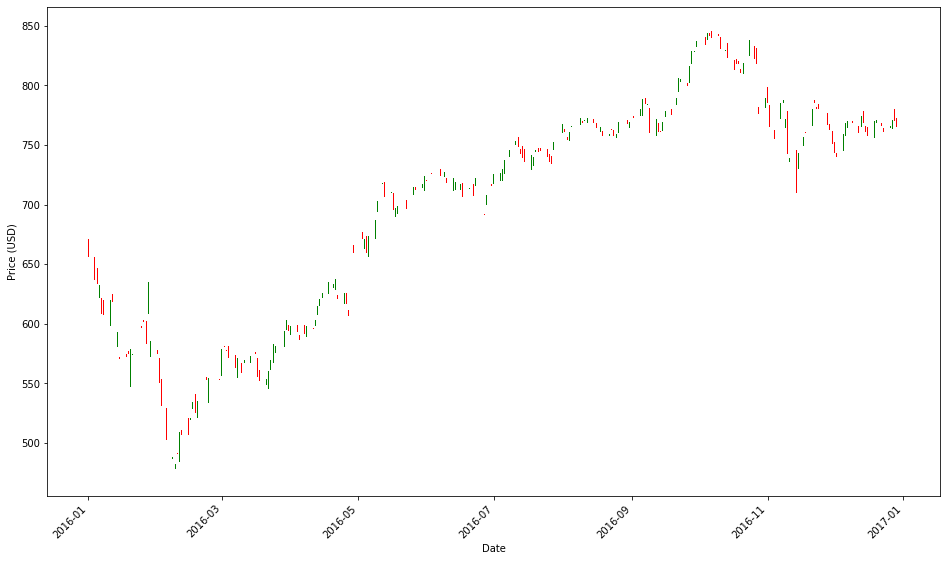

In [16]:
# https://www.statology.org/matplotlib-python-candlestick-chart/

time_period_start = "2016-01-01"
time_period_end = "2017-01-01"

amazon_data_chunk = amazon_data[time_period_start:time_period_end]

plt.figure(figsize=(16,9))

width = 0.4
width2 = 0.05

up = amazon_data_chunk[amazon_data_chunk['Close'] >= amazon_data_chunk['Open']]
down = amazon_data_chunk[amazon_data_chunk['Close'] < amazon_data_chunk['Open']]

# plt.plot(down.index, down["Close"], color='yellow')

# plot up prices
plt.bar(up.index, up["Close"] - up["Open"], width, bottom=up["Open"], color='green')
plt.bar(up.index, up["High"] - up["Close"], width2, bottom=up["Close"], color='green')
plt.bar(up.index, up["Low"] - up["Open"], width2, bottom=up["Open"], color='green')

# plot down prices
plt.bar(down.index, down["Close"] - down["Open"], width, bottom=down["Open"], color='red')
plt.bar(down.index, down['High'] - down["Open"], width2, bottom=down["Open"], color='red')
plt.bar(down.index, down["Low"] - down["Close"], width2, bottom=down["Close"], color='red')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Price (USD)')

#display candlestick chart
plt.show()

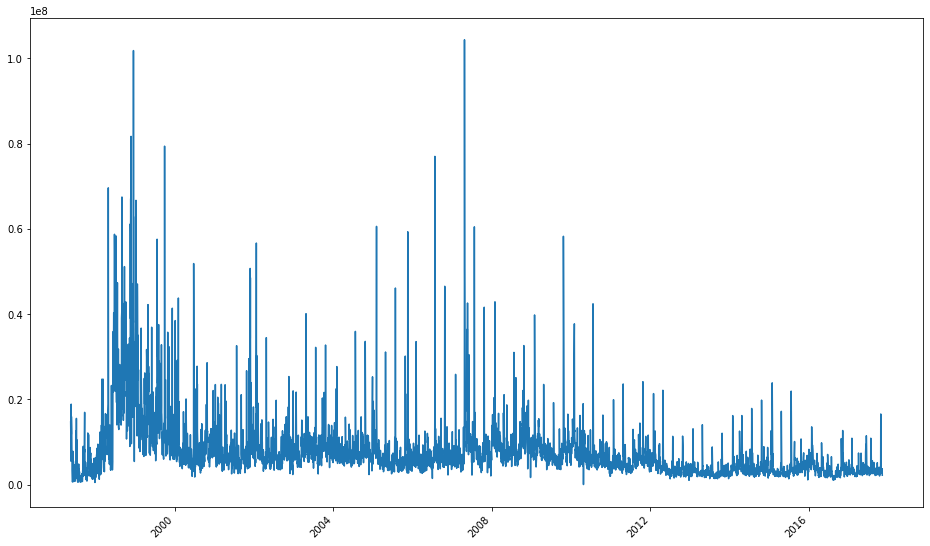

In [17]:
# plot Volume
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Volume"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

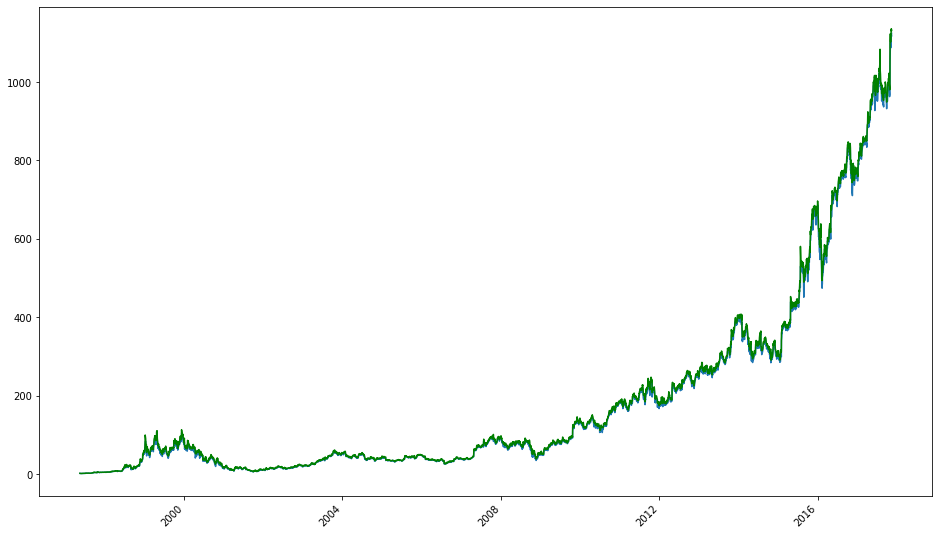

In [18]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Low"])
plt.plot(amazon_data.index, amazon_data["High"], 'green')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

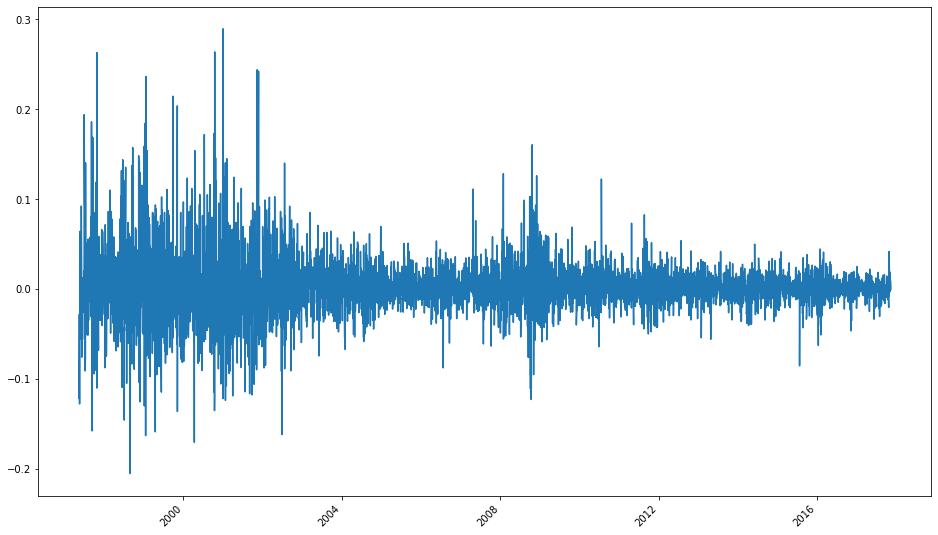

In [19]:
# plot %change
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["%Change"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

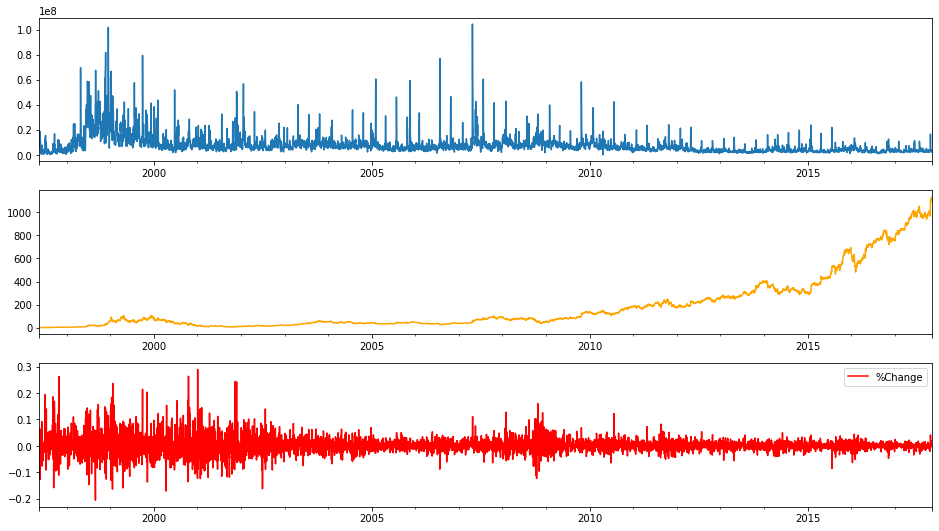

In [20]:
# Plot volume
fig, ax = plt.subplots(3)
amazon_data["Volume"].plot(label='Volume', ax=ax[0])
amazon_data["Close"].plot(color='orange', label='Close', ax=ax[1])
amazon_data["%Change"].plot(color='red', label='%Change', ax=ax[2])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Text(0, 0.5, 'Volume')

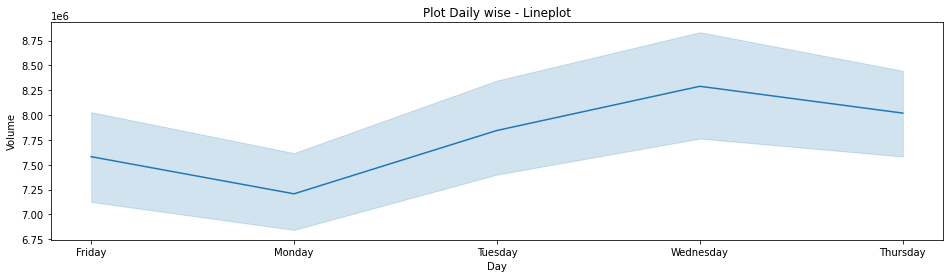

In [21]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Daily wise - Lineplot")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

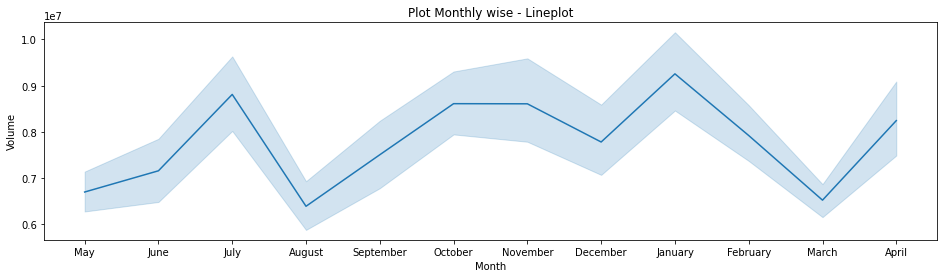

In [22]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Monthly wise - Lineplot")
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

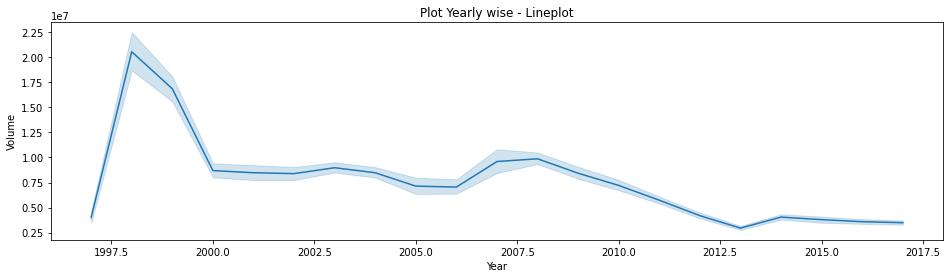

In [23]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Yearly wise - Lineplot")
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

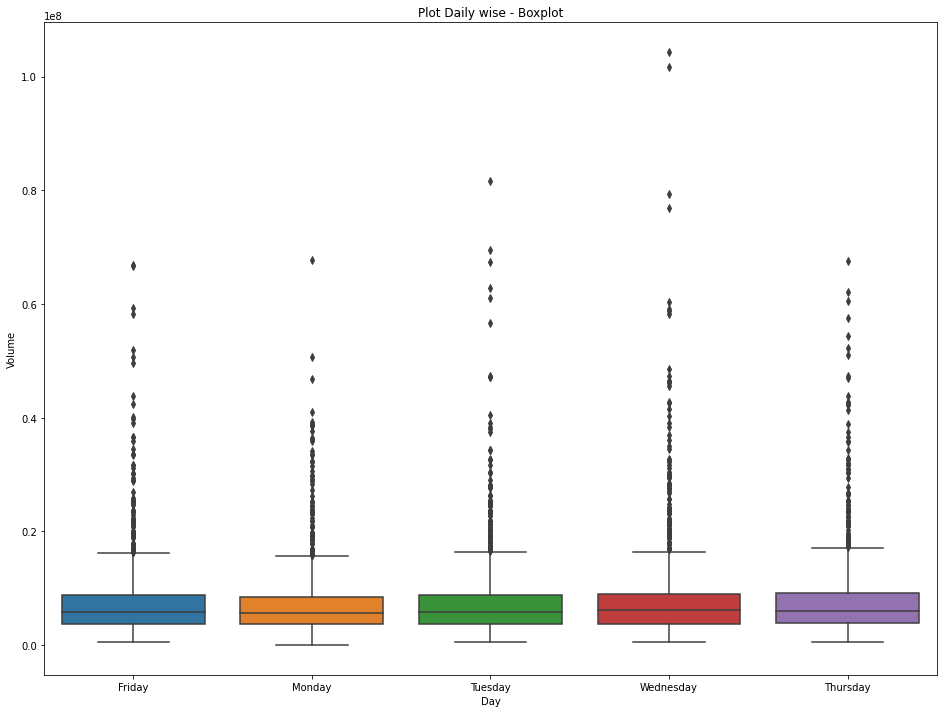

In [24]:
# Boxplot to view daily volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Daily wise - Boxplot")
ax.set_xlabel('Day')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

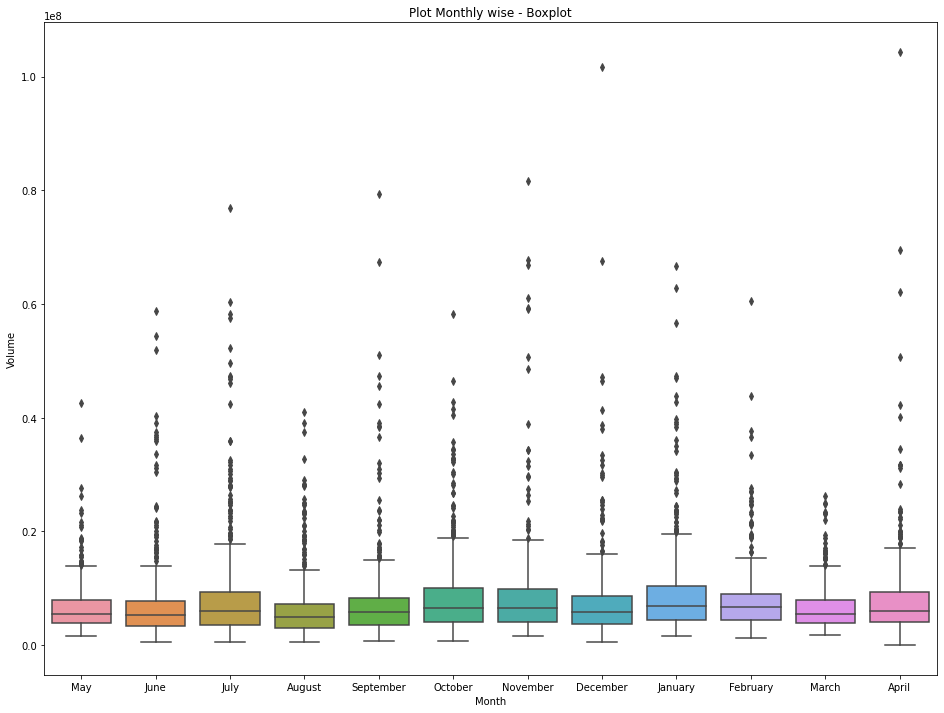

In [25]:
# Boxplot to view monthly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Monthly wise - Boxplot")
ax.set_xlabel('Month')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

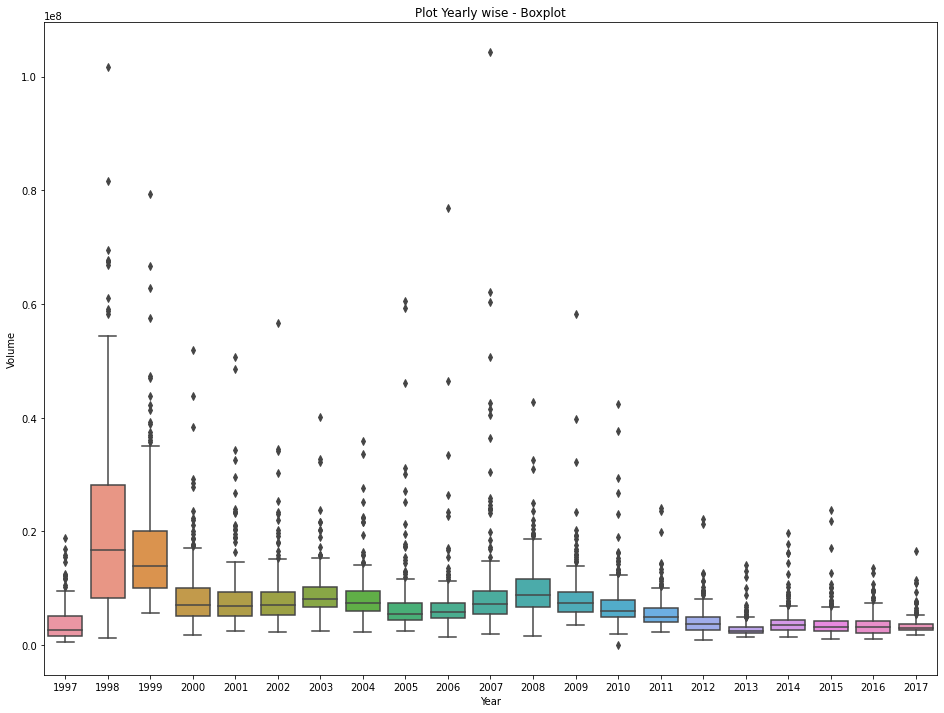

In [26]:
# Boxplot to view yearly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Yearly wise - Boxplot")
ax.set_xlabel('Year')
ax.set_ylabel('Volume')

# Task 3 - AMZN STR Decomposition
Focus now on the AMZN stock volume time series.

a) Split the data into training and testing series, selecting the testing series to be the last three months of the data.

b) Manually step through the STR decomposition process on the training data, as
described in the course material. Visualise and interpret each of the components of the STR decomposition for volume. (Hint: You may wish to validate the output of your manual process against an automated modelling approach.)

In [27]:
# # Remove all data besides stock volume data
# amazon_data.drop(amazon_data.columns.difference(['Datetime', 'Volume']), axis=1, inplace=True)

div = 5 * 4 * 3 # 5 days a week * 4 weeks a month * 3 months
train_amazon = amazon_data['Volume'][:-div]
test_amazon = amazon_data['Volume'][-div:]
prediction_dates = pd.DataFrame(index=test_amazon.index)

In [28]:
train_amazon

1997-05-16    14700000.0
1997-05-19     6106800.0
1997-05-20     5467200.0
1997-05-21    18853200.0
1997-05-22    11776800.0
                 ...    
2017-08-14     3168518.0
2017-08-15     2544672.0
2017-08-16     3125793.0
2017-08-17     3474358.0
2017-08-18     3276718.0
Freq: B, Name: Volume, Length: 5286, dtype: float64

In [29]:
test_amazon

2017-08-21     3157620.0
2017-08-22     2745802.0
2017-08-23     2644883.0
2017-08-24     5192822.0
2017-08-25     3318454.0
2017-08-28     2580401.0
2017-08-29     2871789.0
2017-08-30     2898148.0
2017-08-31     3327043.0
2017-09-01     2533975.0
2017-09-04     2765332.5
2017-09-05     2996690.0
2017-09-06     2125703.0
2017-09-07     2562567.0
2017-09-08     2589603.0
2017-09-11     2172012.0
2017-09-12     2476747.0
2017-09-13     3362218.0
2017-09-14     3900801.0
2017-09-15     3751327.0
2017-09-18     3400824.0
2017-09-19     2651065.0
2017-09-20     2755736.0
2017-09-21     2276738.0
2017-09-22     2632770.0
2017-09-25     5115458.0
2017-09-26     3562792.0
2017-09-27     3146172.0
2017-09-28     2521390.0
2017-09-29     2513654.0
2017-10-02     2425704.0
2017-10-03     2665119.0
2017-10-04     2518564.0
2017-10-05     3223573.0
2017-10-06     3779449.0
2017-10-09     2936290.0
2017-10-10     3083184.0
2017-10-11     2335171.0
2017-10-12     4083590.0
2017-10-13     2429486.0


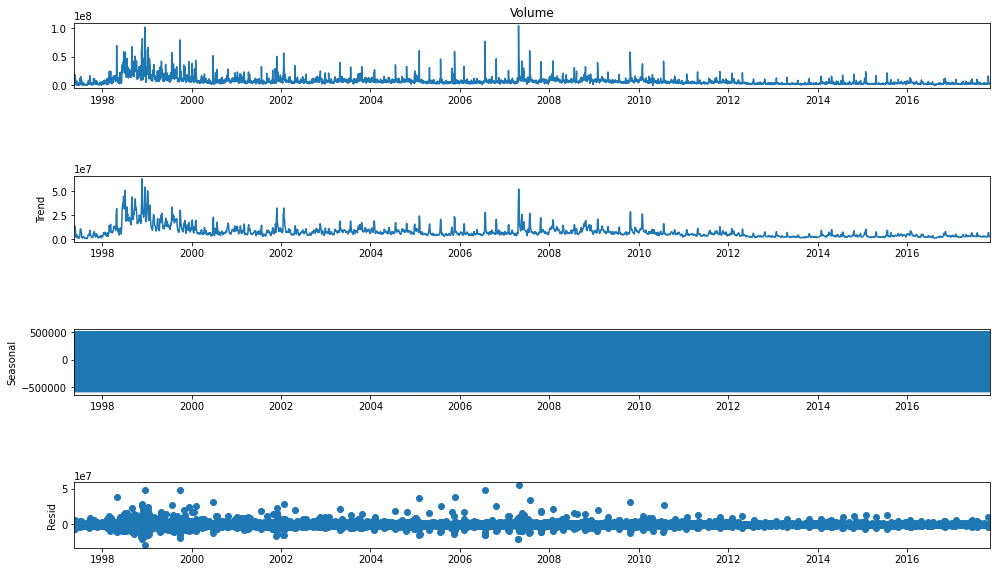

In [30]:
# Jumping ahead - automatic decomposition of temp
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(amazon_data['Volume'],period = (5))
fig = str_res.plot()
fig.set_size_inches((16, 9))

### Isolate Trend
Since we have a weekly cycle we can roll to 1 and 2 weeks and look at the plot

In [31]:
amazon_data['MA5 Trend'] = amazon_data['Volume'].rolling(5).mean() # 1 week
amazon_data['MA10 Trend'] = amazon_data['Volume'].rolling(10).mean() # 2 week
amazon_data['MA20 Trend'] = amazon_data['Volume'].rolling(20).mean() # 1 month
amazon_data['MA60 Trend'] = amazon_data['Volume'].rolling(60).mean() # 3 months
amazon_data['MA120 Trend'] = amazon_data['Volume'].rolling(120).mean() # 6 months
amazon_data['MA180 Trend'] = amazon_data['Volume'].rolling(180).mean() # 9 months
amazon_data['MA240 Trend'] = amazon_data['Volume'].rolling(240).mean() # 12 months
amazon_data['MA480 Trend'] = amazon_data['Volume'].rolling(480).mean() # 24 months
amazon_data['MA720 Trend'] = amazon_data['Volume'].rolling(720).mean() # 36 months

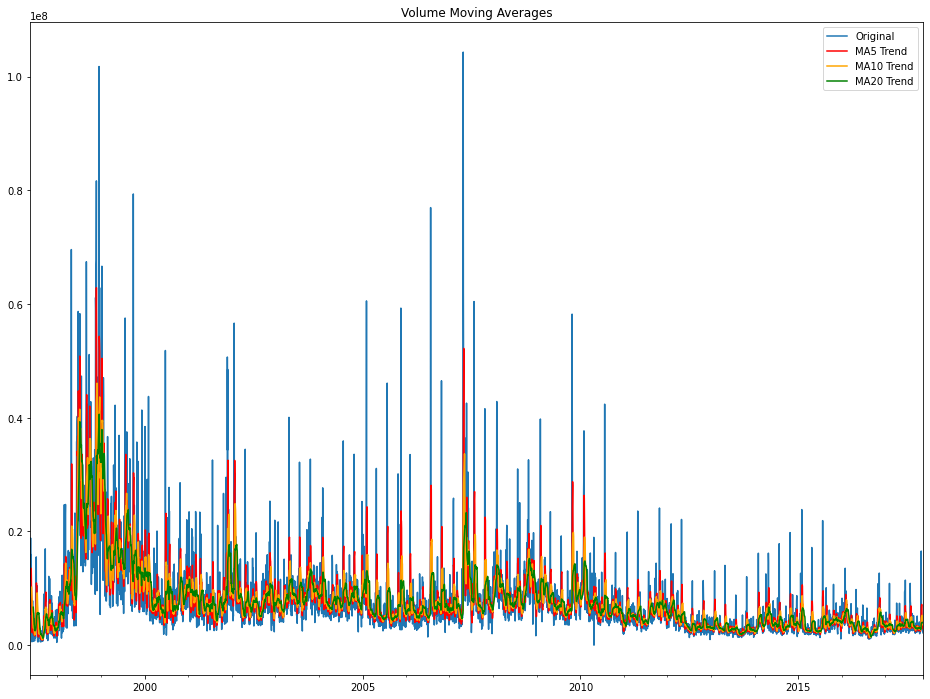

In [32]:
fig, ax = plt.subplots()
amazon_data['Volume'].plot(label='Original', ax=ax)
amazon_data['MA5 Trend'].plot(color='red', label='MA5 Trend', ax=ax)
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax)
amazon_data['MA20 Trend'].plot(color='green', label='MA20 Trend', ax=ax)
# amazon_data['MA60 Trend'].plot(color='orange', label='MA60 Trend', ax=ax)
# amazon_data['MA120 Trend'].plot(color='blue', label='MA60 Trend', ax=ax)
# amazon_data['MA180 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax) # chosen in tut
# amazon_data['MA240 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA480 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA720 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
plt.title('Volume Moving Averages')
fig.set_size_inches((16, 12))
plt.legend()
plt.show()

<AxesSubplot:>

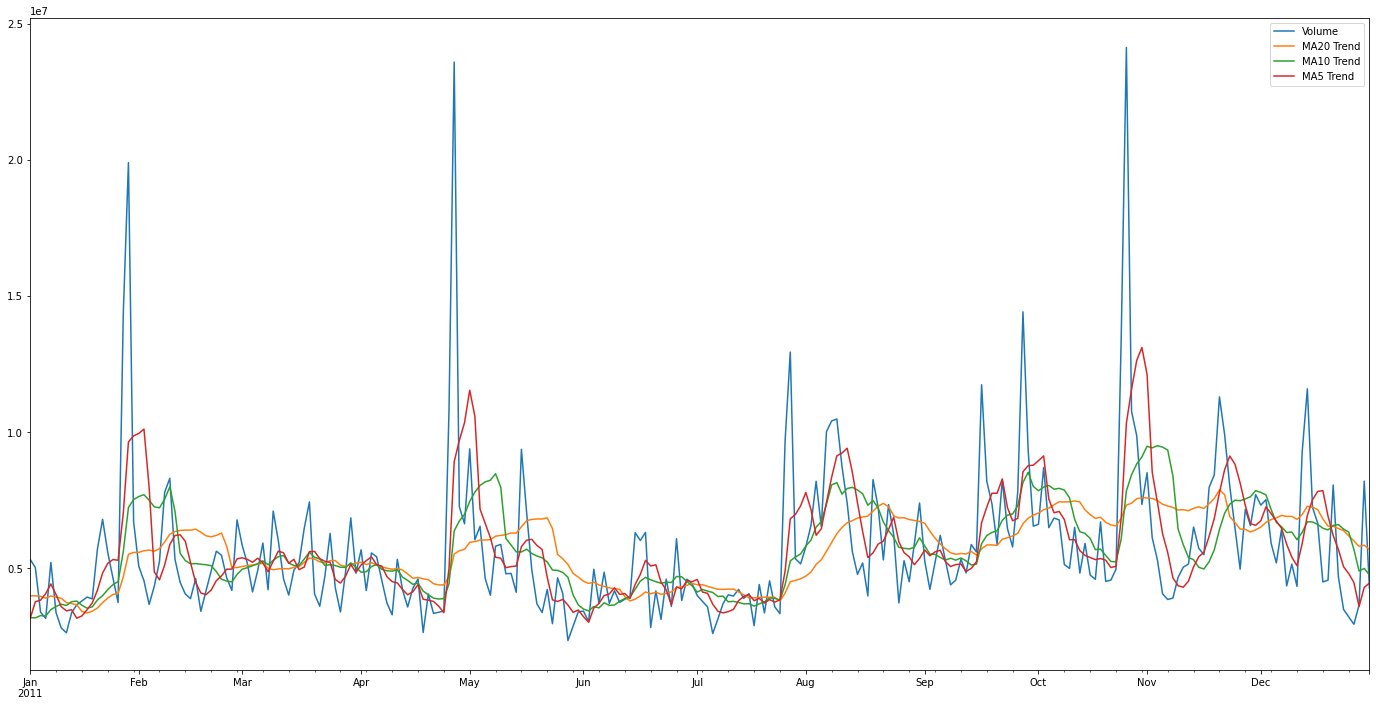

In [33]:
amazon_data['2011':'2011'][['Volume', 'MA20 Trend', 'MA10 Trend', 'MA5 Trend']].plot(figsize=(24,12))

<AxesSubplot:>

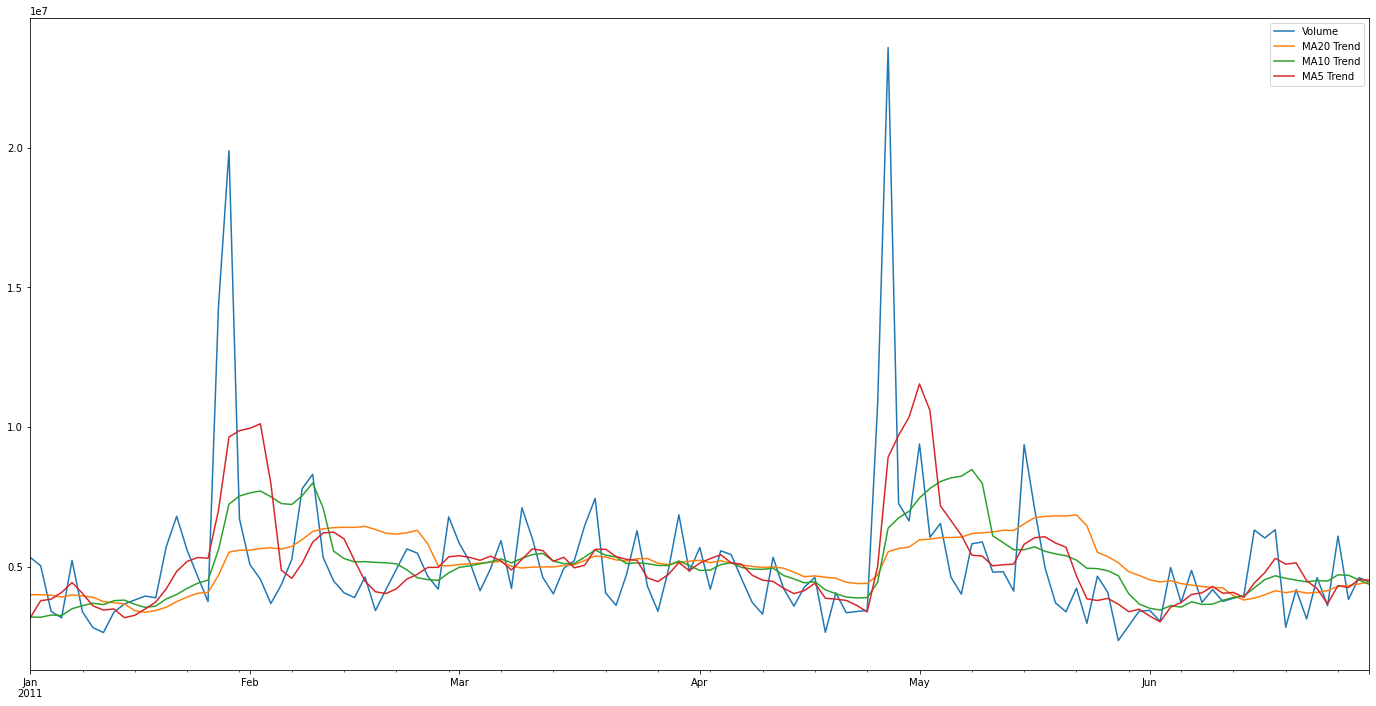

In [34]:
amazon_data['2011-01':'2011-06'][['Volume', 'MA20 Trend', 'MA10 Trend', 'MA5 Trend']].plot(figsize=(24,12))

Go with MA-5 shows a pattern but its not seasonality??

In [35]:
rolling_period = 'MA5 Trend'

### Detrend the Series

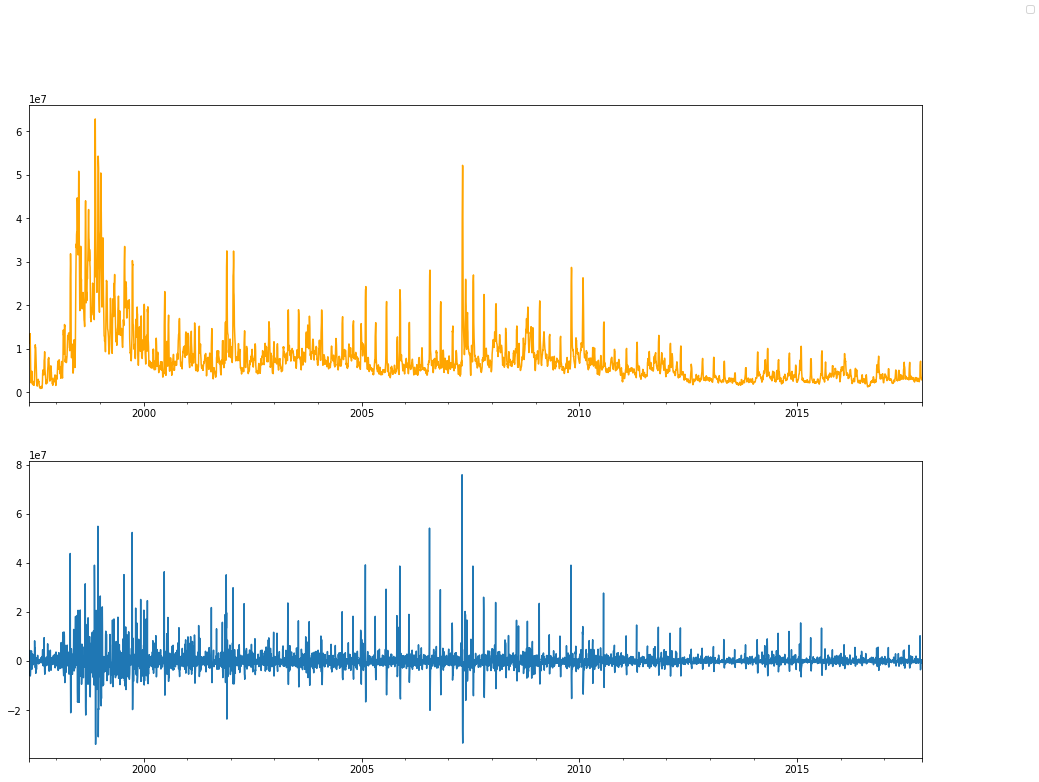

In [36]:
# De-trended data
amazon_data['De-trended'] = amazon_data['Volume'] - amazon_data[rolling_period]

fig, ax = plt.subplots(2)
amazon_data[rolling_period].plot(color='orange', label=rolling_period, ax=ax[0])
amazon_data['De-trended'].plot(label='De-trended', ax=ax[1])
fig.set_size_inches((16, 12))
fig.legend([])
plt.show()

### Estimate seasonal component

<AxesSubplot:>

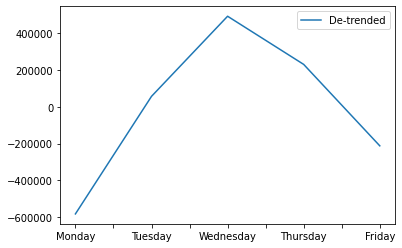

In [37]:
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://sparkbyexamples.com/pandas/pandas-remap-values-in-column-with-a-dictionary-dict/
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe
raw_daily_means = amazon_data.groupby(amazon_data.index.dayofweek)['De-trended'].mean()
raw_daily_means = raw_daily_means.to_frame()
raw_daily_means = raw_daily_means.rename(index={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4:'Friday'})
raw_daily_means.plot()

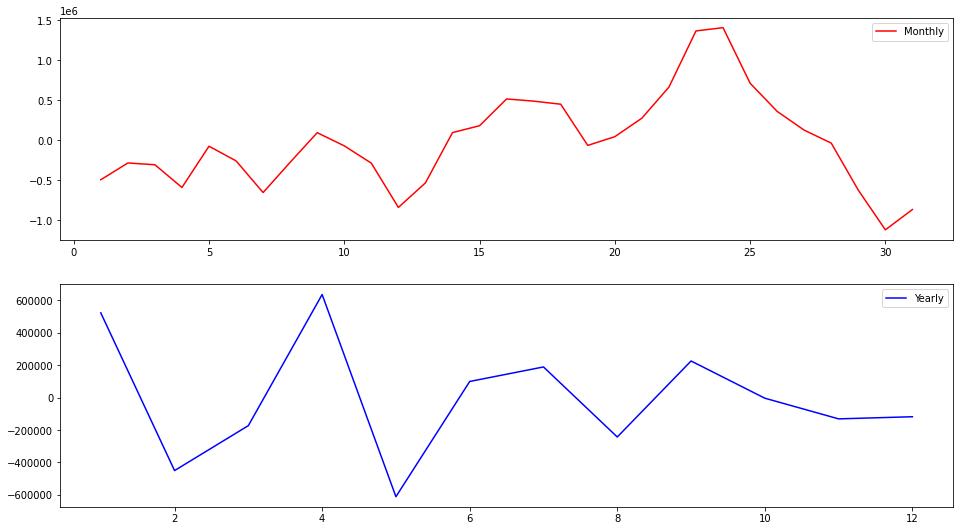

In [38]:
# Test seasonal component for monthly data
raw_monthly_means = amazon_data.groupby(amazon_data.index.day)['De-trended'].mean()
raw_yearly_means = amazon_data.groupby(amazon_data.index.month)['De-trended'].mean()

fig, (ax1, ax2) = plt.subplots(2)
# raw_monthly_means.plot(ax=ax[0], color='orange')
# raw_yearly_means.plot(ax=ax[1])
fig.set_size_inches((16, 9))

ax1.plot(raw_monthly_means, color='r', label='Monthly')
ax1.legend(loc='upper right')
ax2.plot(raw_yearly_means, color='b', label='Yearly')
ax2.legend(loc='upper right')

In [39]:
season_length = len(raw_daily_means.index)

Seasonal Components need to sum to zero, we will introduce an adjustment

In [40]:
# Shift values so that seasonal components sum to zero
adjustment = raw_daily_means.sum()/season_length
daily_means = raw_daily_means - adjustment

# daily_means.plot()
# print(type(daily_means))

# Convert df to series
daily_means = daily_means.squeeze()

Now we fill the series for the entire duration of the timeseries
1. Get the lenth of the seasonal data input equal to the length of df_temp
2. Start the seasonal data at the correct time step

In [41]:
# tile the values into the dataframe so that the entire series is filled
seasonal = np.tile(daily_means, int(np.floor(len(amazon_data)/season_length)))

print(f"seasonal length = {len(seasonal)}  amazon_data = {len(amazon_data)}")

seasonal length = 5345  amazon_data = 5346


There is one day missing from the seasonal tiled series length.

In [42]:
amazon_data['day'].head()

1997-05-16       Friday
1997-05-19       Monday
1997-05-20      Tuesday
1997-05-21    Wednesday
1997-05-22     Thursday
Freq: B, Name: day, dtype: object

The dataset starts on a Friday but the tiled seasonal series starts on a Monday so we need to add a recording for a Friday onto the start of the Seasonal series.

In [43]:
 # Prepending one observation
seasonal = np.insert(seasonal, 0, daily_means[season_length - 1])

amazon_data['temp-seasonal'] = seasonal

<AxesSubplot:>

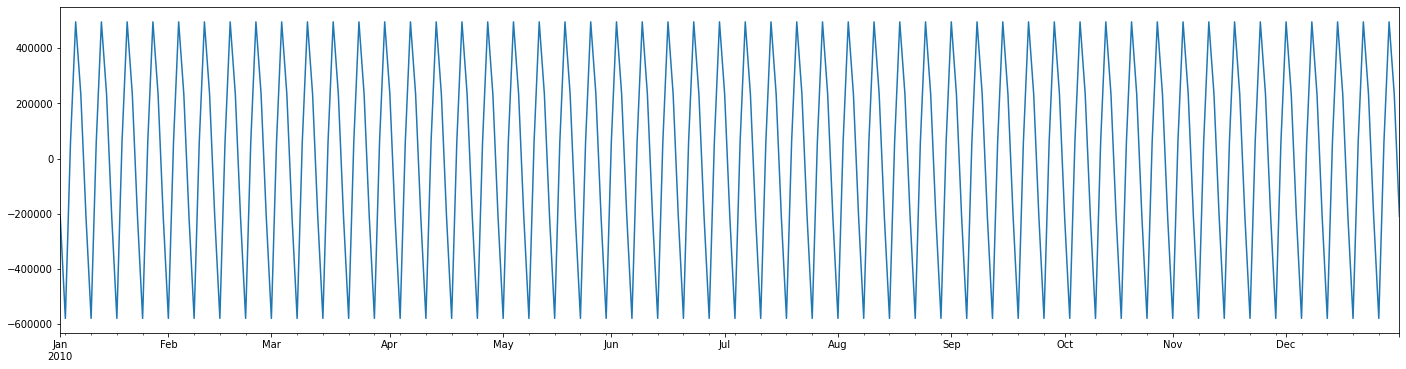

In [44]:
amazon_data['2010':'2010']['temp-seasonal'].plot(figsize=(24,6))

### Calculate the residual component
The last step is to calulate the residual, by subtracting the seasonal component from the detrended data.

<AxesSubplot:>

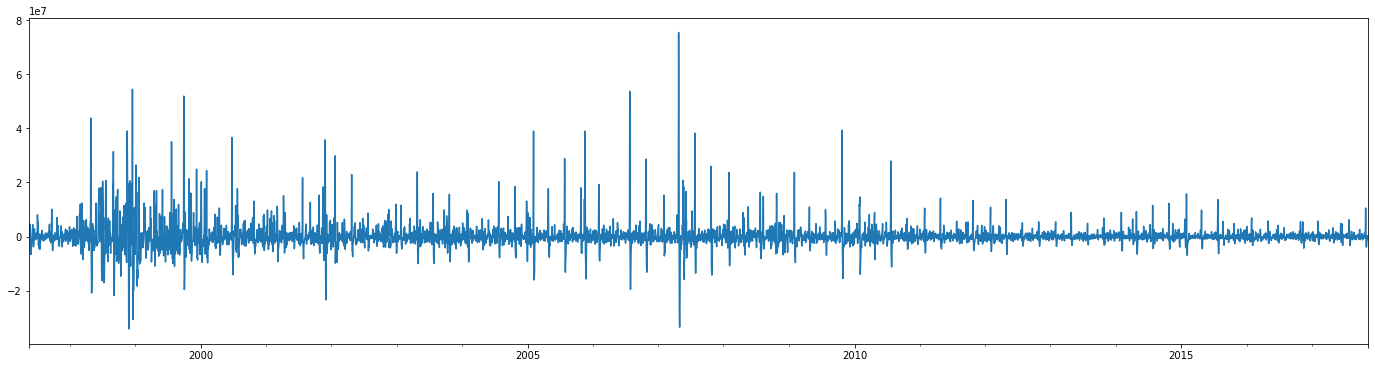

In [45]:
amazon_data['temp-residual'] = amazon_data['De-trended'] - amazon_data['temp-seasonal']
amazon_data['temp-residual'].plot(figsize=(24,6))

Putting all 4 plots into the same figure

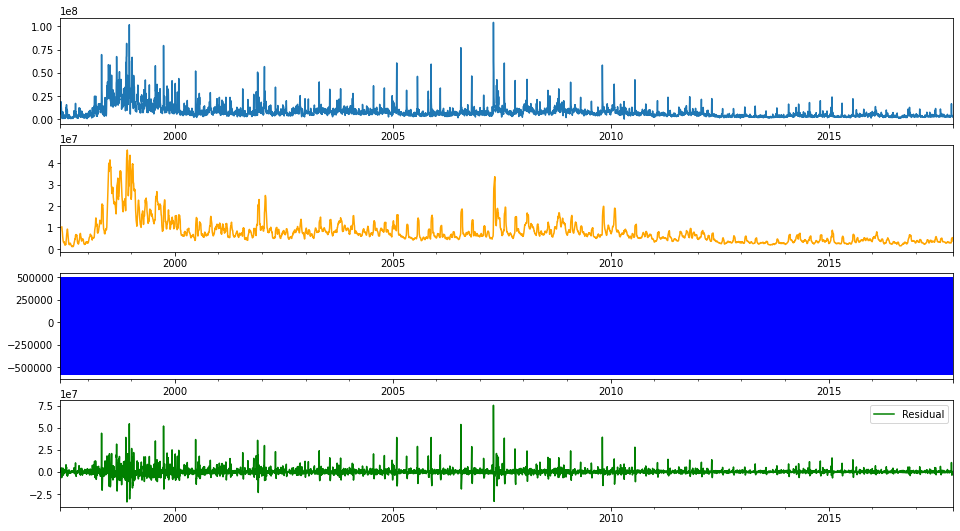

In [46]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume'].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Looking closer at one month

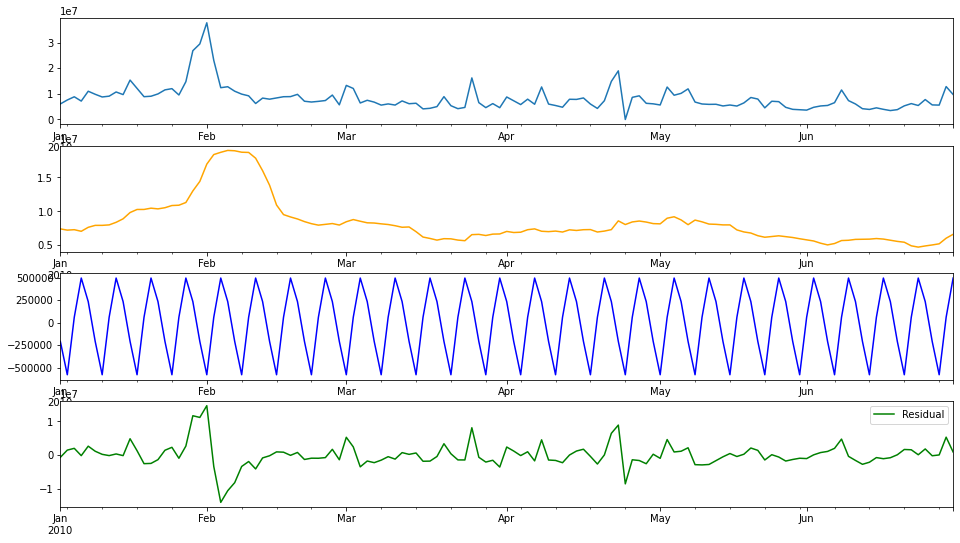

In [47]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume']["2010-01":"2010-06"].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend']["2010-01":"2010-06"].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal']["2010-01":"2010-06"].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual']["2010-01":"2010-06"].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

# Task 4 - Timeseries Models
a) Fit an ARIMA model for the trend-cycle component of your STR decomposition of the training data and interpret the estimated model parameters.

b) Using the STR components that you estimated in tasks 3 and 4, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts and visualise the predictions.

### Check for stationarity
To fig an autoregressive model or an ARIMA model that contains an AR component, the data must be stationary. The criteria for stationarity is that the data is:
- roughly horizontal
- constant variance
- no patterns predictable in the long-term

<AxesSubplot:>

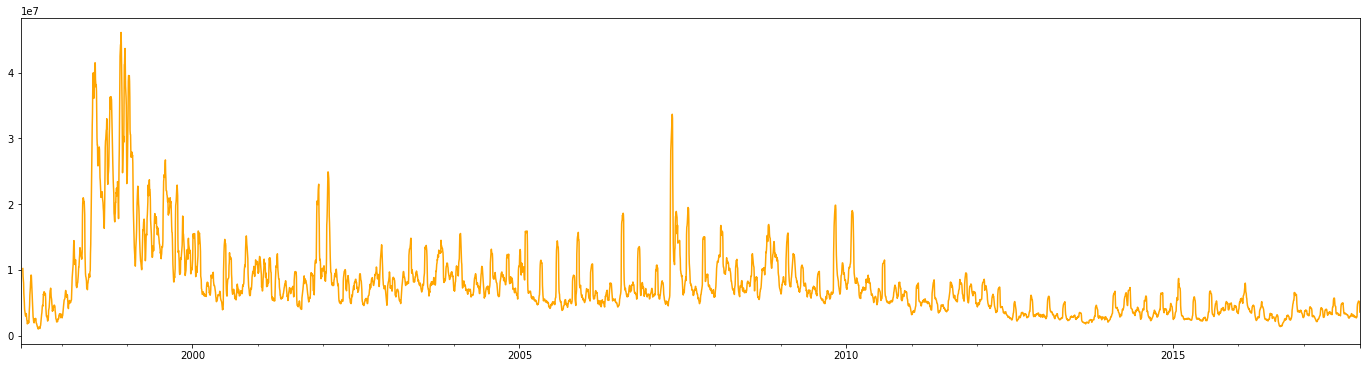

In [48]:
amazon_data['MA10 Trend'].plot(color='orange', figsize=(24,6))

Perform first differencing 

<AxesSubplot:>

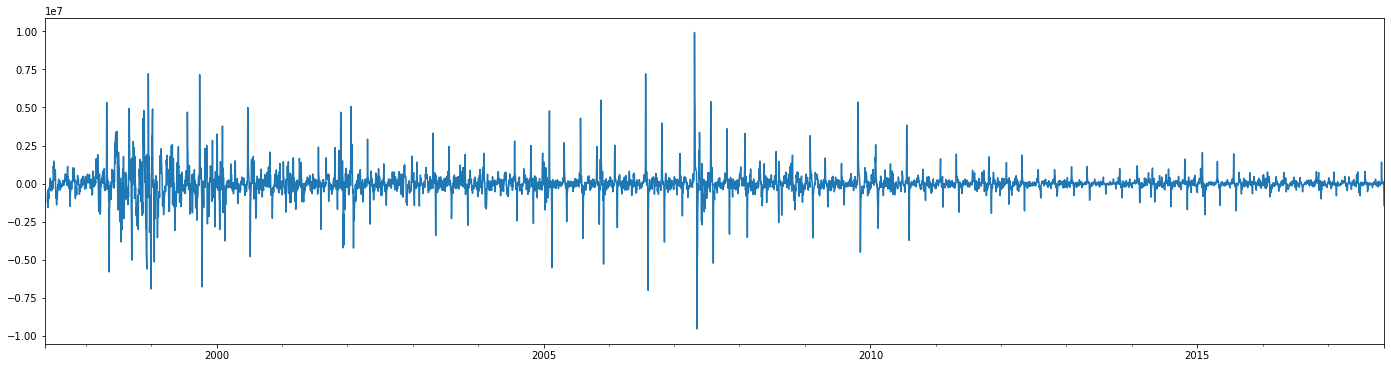

In [49]:
trend_d1 = amazon_data['MA10 Trend'].diff()
trend_d1.plot(figsize=(24,6))

<AxesSubplot:>

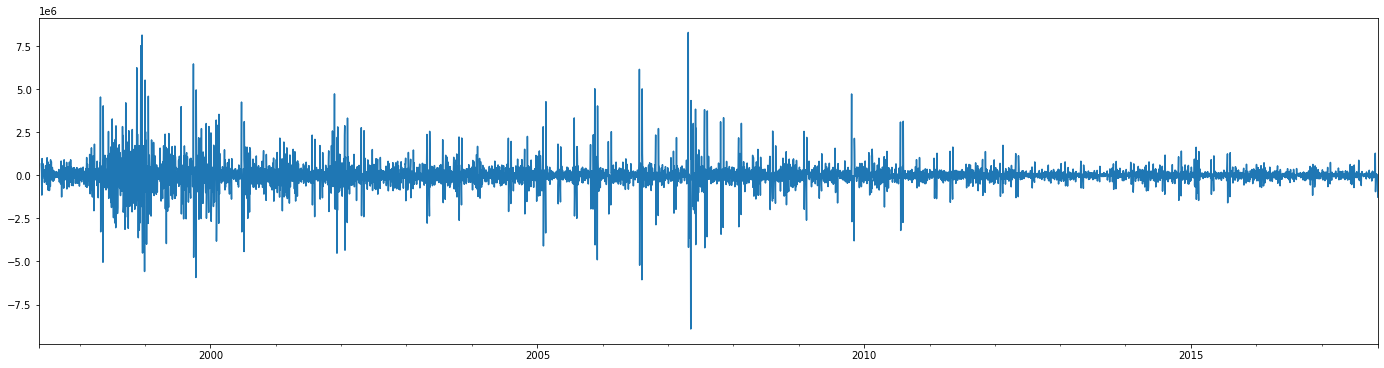

In [50]:
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6))

The differencing plot does not seem to change when going from first to second differencing. Therefore, we will select the first differencing. 

d = 1

## Fit a lower order model

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

## Is there Evidence of autocorrelation?

In [52]:
# trim th nan's from the differenced trend
trend_d1 = trend_d1[10:].copy()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


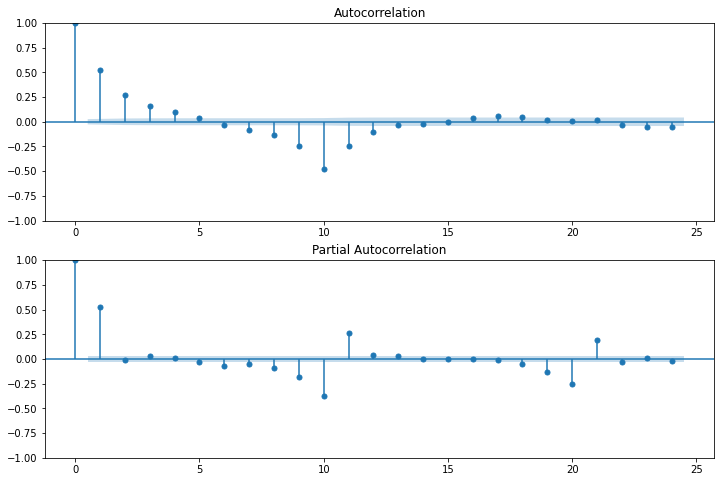

In [53]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1, lags=24, ax=ax2)

### Fit the ARIMA Model

In [54]:
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,year,month,...,MA20 Trend,MA60 Trend,MA120 Trend,MA180 Trend,MA240 Trend,MA480 Trend,MA720 Trend,De-trended,temp-seasonal,temp-residual
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-209204.206192,NaN
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-579309.477485,NaN
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59789.655848,NaN
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,495282.021173,NaN
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396000.0,233442.006655,1.625580e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377,2017,November,...,4000098.35,3.342046e+06,3.648555e+06,3.498894e+06,3.478742e+06,3.534581e+06,3.570897e+06,-268376.4,-579309.477485,3.109331e+05
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396,2017,November,...,3980161.30,3.344375e+06,3.650822e+06,3.498752e+06,3.474467e+06,3.530841e+06,3.565999e+06,-757166.6,59789.655848,-8.169563e+05
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960,2017,November,...,3992203.25,3.335212e+06,3.651814e+06,3.498340e+06,3.470456e+06,3.527808e+06,3.563786e+06,-629699.4,495282.021173,-1.124981e+06
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815,2017,November,...,3974522.65,3.339473e+06,3.642747e+06,3.507424e+06,3.472950e+06,3.521193e+06,3.558904e+06,515248.2,233442.006655,2.818062e+05


In [55]:
arima_train = amazon_data[rolling_period][4:-div]
arima_test = amazon_data[rolling_period][-div:]

# arima_train['Datetime String'] = arima_train.index
arima_train
# type(arima_data)

1997-05-22    11380800.0
1997-05-23    11628240.0
1997-05-26    12870360.0
1997-05-27    13516440.0
1997-05-28    10660680.0
                 ...    
2017-08-14     3738813.8
2017-08-15     3669845.2
2017-08-16     3581375.2
2017-08-17     3155645.0
2017-08-18     3118011.8
Freq: B, Name: MA5 Trend, Length: 5282, dtype: float64

In [56]:
arima_1_1_0 = ARIMA(arima_train, order=(1, 1, 0)).fit()
# print(arima_1_1_0.summary())

In [57]:
# arima_1_1_0.predict(start="2017-08-17", end="2017-11-10")

In [58]:
arima_2_1_0 = ARIMA(arima_train, order=(2, 1, 0)).fit()
print(arima_2_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:              MA5 Trend   No. Observations:                 5282
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -82094.665
Date:                Thu, 03 Nov 2022   AIC                         164195.330
Time:                        08:03:51   BIC                         164215.046
Sample:                    05-22-1997   HQIC                        164202.221
                         - 08-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5206      0.007     72.493      0.000       0.507       0.535
ar.L2         -0.0604      0.007     -8.060      0.000      -0.075      -0.046
sigma2      1.857e+12   3.02e-15   6.15e+26      0.0

### Comparing Goodness of fit of ARIMA models

Looking at the outputs: 
- AIC for ARIMA(1,1,0) = 158443, for ARIMA(2,1,0) = 158427
- BIC for ARIMA(1,1,0) = 158456, for ARIMA(2,1,0) = 158447
The drop in AIC and BIC is very small so therefore we will go with ARIMA(1,1,0)

Next we will see if ARIMA(1,1,1) gives us any improvements

In [59]:
arima_1_1_1 = ARIMA(arima_train, order=(1, 1, 1)).fit()
print(arima_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:              MA5 Trend   No. Observations:                 5282
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -82096.534
Date:                Thu, 03 Nov 2022   AIC                         164199.068
Time:                        08:03:53   BIC                         164218.784
Sample:                    05-22-1997   HQIC                        164205.959
                         - 08-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4148      0.013     31.261      0.000       0.389       0.441
ma.L1          0.1010      0.015      6.653      0.000       0.071       0.131
sigma2      1.858e+12   3.28e-15   5.67e+26      0.0

Looking at the outputs: 
- AIC for ARIMA(1,1,0) = 158443, for ARIMA(1,1,1) = 158430
- BIC for ARIMA(1,1,0) = 158456, for ARIMA(1,1,1) = 158450
Again, the drop in AIC and BIC is very small so therefore we will go with ARIMA(1,1,0)

### Inspect the residuals

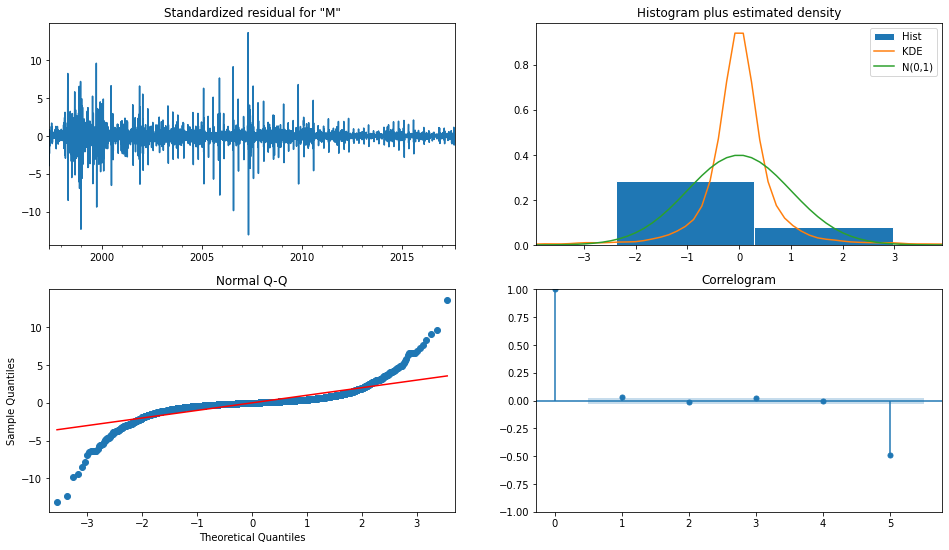

In [60]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_0.plot_diagnostics(fig=fig, lags=5)

In [61]:
# amazon_data.head(20)
test_amazon.index
# print(type(test_amazon.index))
print(type(arima_train))

<class 'pandas.core.series.Series'>


In [62]:
arima_pred = pd.DataFrame(index=test_amazon.index)

# # print(test_amazon.index)
# # arima_pred['Trend'] = arima_1_1_0.predict(dates=prediction_dates)
# arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-17", end="2017-08-18")
# start = len(train_amazon)
# end = len(train_amazon) + len(test_amazon) - 1
# # arima_pred['Trend'] = arima_1_1_0.predict(start=start, end=end)
# arima_pred.head(100)

In [63]:
arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-17", end="2017-08-25")

In [64]:
#  https://stackoverflow.com/questions/58580633/the-start-argument-could-not-be-matched-to-a-location-related-to-the-index-of
# arima_1_1_0 last date is 2017-08-17 I want to predict up to 2017-11-10
# arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-17", end="2017-11-10")
arima_pred['Trend'] = arima_1_1_0.predict(start=train_amazon.shape[0], end=(train_amazon.shape[0] + test_amazon.shape[0] - 1))

In [65]:
arima_pred['Trend']

2017-08-21             NaN
2017-08-22             NaN
2017-08-23             NaN
2017-08-24             NaN
2017-08-25    3.082820e+06
2017-08-28    3.082297e+06
2017-08-29    3.082040e+06
2017-08-30    3.081914e+06
2017-08-31    3.081852e+06
2017-09-01    3.081822e+06
2017-09-04    3.081807e+06
2017-09-05    3.081800e+06
2017-09-06    3.081796e+06
2017-09-07    3.081794e+06
2017-09-08    3.081793e+06
2017-09-11    3.081793e+06
2017-09-12    3.081793e+06
2017-09-13    3.081793e+06
2017-09-14    3.081793e+06
2017-09-15    3.081793e+06
2017-09-18    3.081793e+06
2017-09-19    3.081793e+06
2017-09-20    3.081793e+06
2017-09-21    3.081793e+06
2017-09-22    3.081793e+06
2017-09-25    3.081793e+06
2017-09-26    3.081793e+06
2017-09-27    3.081793e+06
2017-09-28    3.081793e+06
2017-09-29    3.081793e+06
2017-10-02    3.081793e+06
2017-10-03    3.081793e+06
2017-10-04    3.081793e+06
2017-10-05    3.081793e+06
2017-10-06    3.081793e+06
2017-10-09    3.081793e+06
2017-10-10    3.081793e+06
2

In [66]:
# Using forcast
arima_fcst = arima_1_1_0.get_forecast(steps=60)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)
# arima_predictions.head()

In [67]:
# print(f"length predictions = {len(prediction_dates)}  length pred = {len(arima_predictions)}")
# print(type(arima_predictions))
# set the index to be the dates
# arima_predictions['Datetime'] = prediction_dates

arima_predictions.index = prediction_dates.index
# amazon_data = amazon_data.set_index('Datetime')
# arima_predictions

In [68]:
# train_amazon.head()

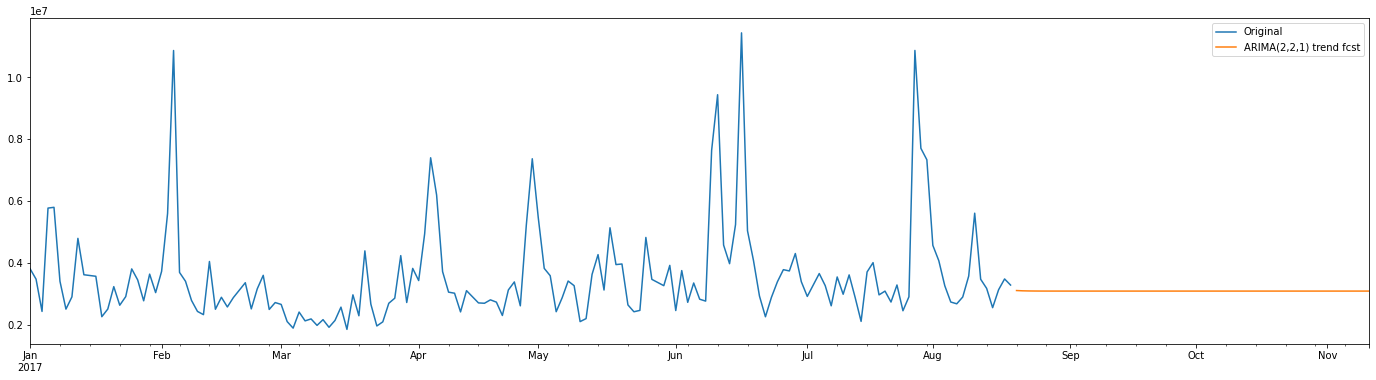

In [69]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train_amazon['2017':'2017'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['2017':'2017']['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
plt.legend()

### Add Seasonality back into forecasts

In [70]:
# amazon_data['2010':'2010']['temp-seasonal'].plot(figsize=(24,6))
# print(type(prediction_dates.index.to_list()))
# amazon_data.loc(prediction_dates.index.to_list())

# amazon_data[-div:]['temp-seasonal']

arima_predictions['seasonal'] = amazon_data[-div:]['temp-seasonal']
arima_predictions.head(60)

,trend,seasonal
2017-08-21,3.099555e+06,-579309.477485
2017-08-22,3.090504e+06,59789.655848
2017-08-23,3.086065e+06,495282.021173
2017-08-24,3.083888e+06,233442.006655
2017-08-25,3.082820e+06,-209204.206192
2017-08-28,3.082297e+06,-579309.477485
2017-08-29,3.082040e+06,59789.655848
2017-08-30,3.081914e+06,495282.021173
2017-08-31,3.081852e+06,233442.006655
2017-09-01,3.081822e+06,-209204.206192


In [71]:
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions.tail()

,trend,seasonal,trend+seasonal
2017-11-06,3.081793e+06,-579309.477485,2.502483e+06
2017-11-07,3.081793e+06,59789.655848,3.141582e+06
2017-11-08,3.081793e+06,495282.021173,3.577075e+06
2017-11-09,3.081793e+06,233442.006655,3.315235e+06
2017-11-10,3.081793e+06,-209204.206192,2.872588e+06


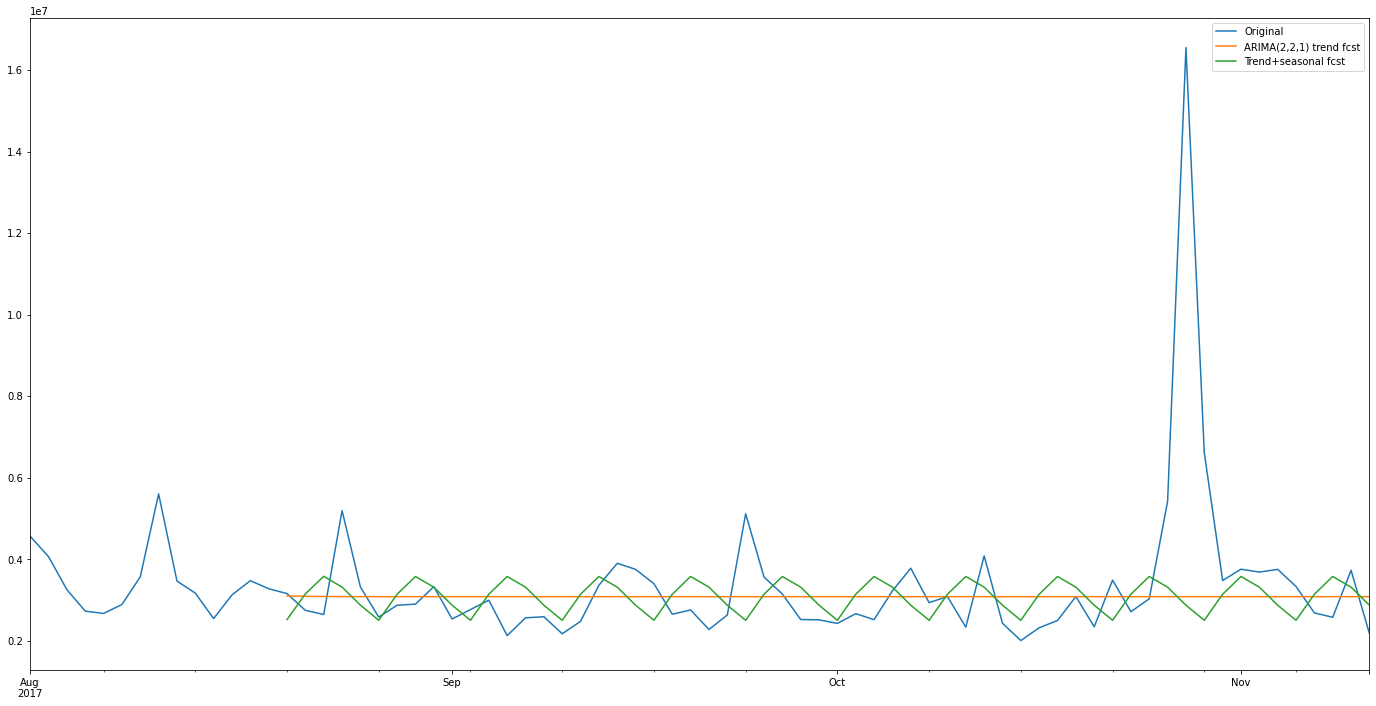

In [72]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,12))
amazon_data["2017-08":"2017-12"]['Volume'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

Plotting a confidence interval for the trend.

In [73]:
# from pandas import datetime
# start = datetime(2017, 8, 18)
# end = datetime(2017, 11, 10)

# fig, ax_arima_fcst = plt.subplots(figsize=(24,12))
# amazon_data["2017-08":"2017-12"]['Volume'].plot(label='Original', ax=ax_arima_fcst)
# fig = plot_predict(arima_1_1_0, start=start, end=end, label='ARIMA(2,2,1) Forecast', ax=ax_arima_fcst)

# Task 5 - Pure Forcasters
now consider your choice of ML techniques

a) Select an appropriate pure forecasting method to predict the trend component of the volume training data.

b) Using the seasonal component that you estimated in task 3 and the pure forecaster from 5.a, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts, and visualise the predictions.

In [74]:
# !pip3 uninstall tensorflow-cpu -y
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

2022-11-03 08:03:56.990129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 08:03:57.374398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 08:03:57.374486: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 08:03:57.442143: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 08:03:59.244219: W tensorflow/stream_executor/platform/de

Scale the data and split into train test.

In [75]:
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,year,month,...,MA20 Trend,MA60 Trend,MA120 Trend,MA180 Trend,MA240 Trend,MA480 Trend,MA720 Trend,De-trended,temp-seasonal,temp-residual
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-209204.206192,NaN
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-579309.477485,NaN
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59789.655848,NaN
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,495282.021173,NaN
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396000.0,233442.006655,1.625580e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377,2017,November,...,4000098.35,3.342046e+06,3.648555e+06,3.498894e+06,3.478742e+06,3.534581e+06,3.570897e+06,-268376.4,-579309.477485,3.109331e+05
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396,2017,November,...,3980161.30,3.344375e+06,3.650822e+06,3.498752e+06,3.474467e+06,3.530841e+06,3.565999e+06,-757166.6,59789.655848,-8.169563e+05
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960,2017,November,...,3992203.25,3.335212e+06,3.651814e+06,3.498340e+06,3.470456e+06,3.527808e+06,3.563786e+06,-629699.4,495282.021173,-1.124981e+06
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815,2017,November,...,3974522.65,3.339473e+06,3.642747e+06,3.507424e+06,3.472950e+06,3.521193e+06,3.558904e+06,515248.2,233442.006655,2.818062e+05


In [76]:
# We will use the previous 5 observations of the volume as the features used to predict future values
prev_data = pd.concat([amazon_data['Volume'], 
                 amazon_data['Volume'].shift(), 
                 amazon_data['Volume'].shift(2),
                 amazon_data['Volume'].shift(3),
                 amazon_data['Volume'].shift(4)], 
                 axis=1
                 ).dropna()

In [77]:
amazon_np_arr = np.array(prev_data)

In [78]:
train, test = amazon_np_arr[:-div], amazon_np_arr[-div:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

In [79]:
train_scaled

array([[0.11288163, 0.18070953, 0.05240358, 0.0585342 , 0.14090076],
       [0.15275942, 0.11288163, 0.18070953, 0.05240358, 0.0585342 ],
       [0.11806333, 0.15275942, 0.11288163, 0.18070953, 0.05240358],
       ...,
       [0.02996099, 0.0243909 , 0.03037052, 0.03321121, 0.05370532],
       [0.03330202, 0.02996099, 0.0243909 , 0.03037052, 0.03321121],
       [0.03140762, 0.03330202, 0.02996099, 0.0243909 , 0.03037052]])

In [80]:
# Configure model
learning_rate = 0.001

In [81]:
# Single layer FF network with RLU
def slff_relu(input_dim,hidden_1_dim = 64):
    # Single-layer FF network with Rectified linear unit (relu) activation fxn
    inputs = keras.layers.Input(shape=(input_dim))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_1)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [82]:
input_dim = 4
model = slff_relu(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


2022-11-03 08:04:01.434972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 08:04:01.435086: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 08:04:01.435142: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (data2001-5d7daac5.zones.eait.uq.edu.au): /proc/driver/nvidia/version does not exist
2022-11-03 08:04:01.435680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [83]:
# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=20, shuffle=False)

2022-11-03 08:04:01.633507: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84512 exceeds 10% of free system memory.
2022-11-03 08:04:01.634344: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 21128 exceeds 10% of free system memory.


Epoch 1/20


2022-11-03 08:04:01.765163: W tensorflow/core/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency
2022-11-03 08:04:01.779650: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42256 exceeds 10% of free system memory.
2022-11-03 08:04:01.779908: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42256 exceeds 10% of free system memory.
2022-11-03 08:04:01.780846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42256 exceeds 10% of free system memory.


265/265 [==============================] - 1s 2ms/step - loss: 0.0035
Epoch 2/20
265/265 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 3/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0025
Epoch 4/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 5/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 6/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 7/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 8/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 9/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 10/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 11/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 12/20
265/265 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 13/20
265/265 [===============

### Timeseries predictions using neural networks

In [84]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


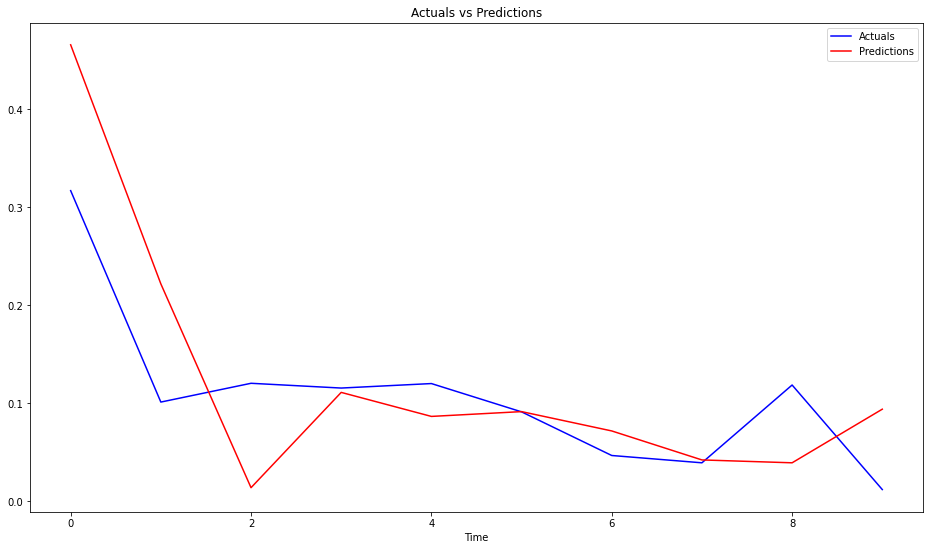

In [85]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=10):
    plt.figure(figsize=(16,9))
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

To get a sense of the goodness of these predictions, we compute and plot the test data errors

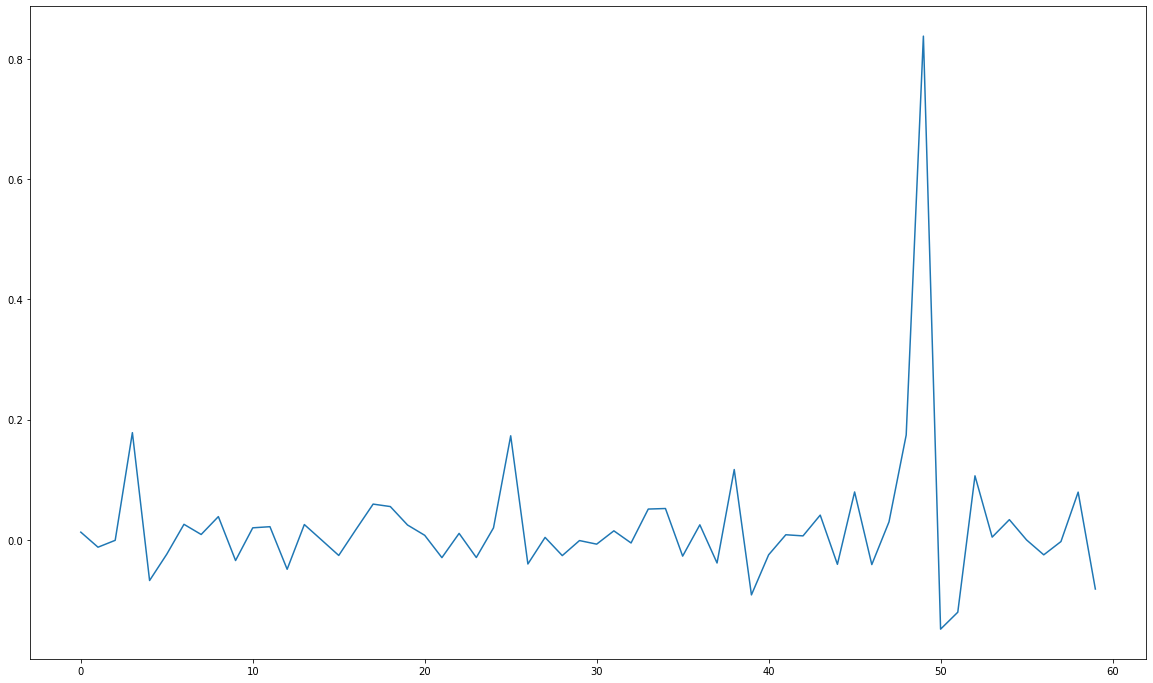

In [86]:
# Compute and plot the test data errors
errors = np.squeeze(y_test) - np.squeeze(y_pred)
plt.figure(figsize=(20,12))
plt.plot(errors)
# plt.figsize=(24,12))

You can conduct further analysis into the test data errors, for example corellograms to ascertain if there is any correlation, or checks of whether the errors are close to normally distributed.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


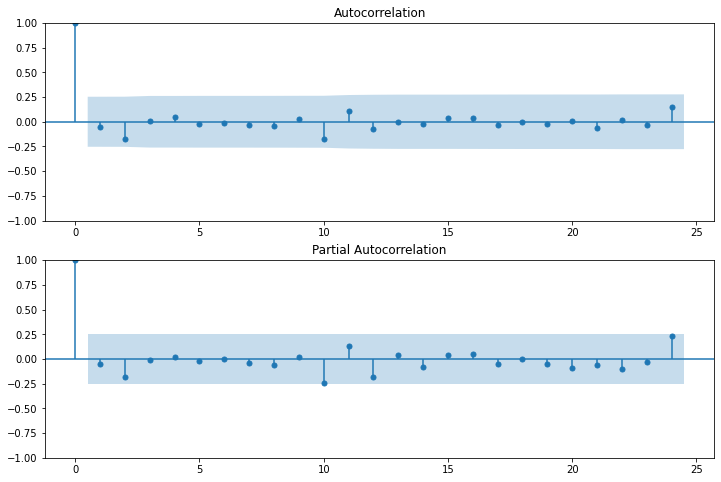

In [87]:
# check for evidence of autocorrelation
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(errors, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(errors, lags=24, ax=ax2)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fff14c9d790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fff14c9dc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fff14c9d4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fff14cad250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fff14cad520>],
 'means': []}

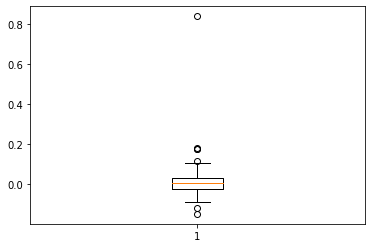

In [88]:
# # counts, bins = np.histogram(errors)
# plt.hist(bins[:-1], bins=10, weights=counts)
# plt.box(counts)
# # errors.plot.box(vert=False, title="Distribution of Culmen Depth (mm)")

fig, ax = plt.subplots()
ax.boxplot(errors)

### Multistep point prediction

In [89]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
        # print("new_y")
        # print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
        # print("y_pred_multi")
        # print(y_pred_multi)
        # print("X_pred_multi")
        # print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
        # print("new X")
        # print(X_pred)
        
    return y_pred_multi, X_pred_multi

1/1 [==============================] - 0s 50ms/step


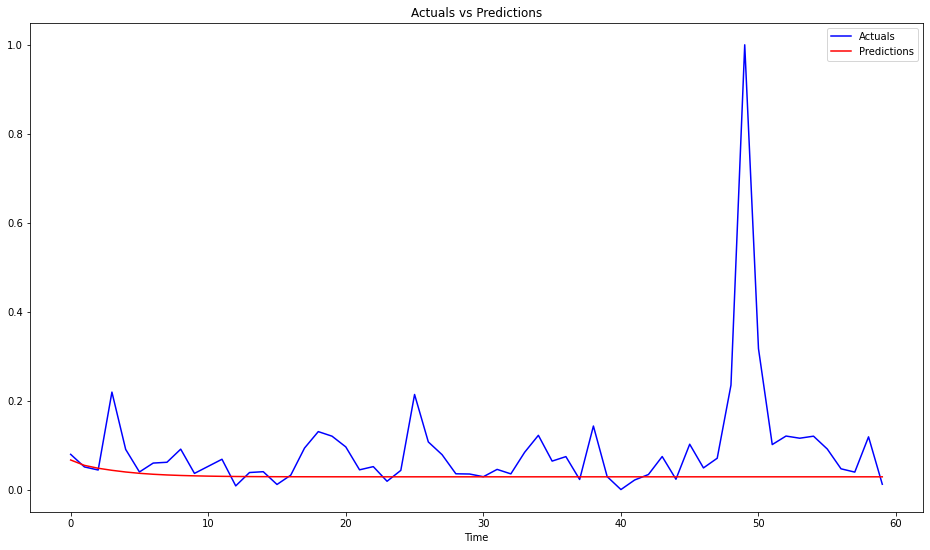

In [90]:
# Prediction horizon
H = 60 # extend prediction horizon to end of dataset

X_test_multi = X_test[-H:,:]
y_test_multi = y_test[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred)
plot_pred(y_test_multi, y_pred_multi, period=H)

### Bootstrapping for interval predictions

In [91]:
residuals = np.squeeze(y_train) - np.squeeze(model.predict(X_train))

166/166 [==============================] - 0s 2ms/step


In [99]:
# Bootstrap iterations
K = 20
# reduce prediction horizon for bootstrap to 1 month, if prediction horizon is 3 months the computation takes too long
H = 60

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred,residuals)
    # store y predictions
    y_pred_bootstrap.append(y_pred_multi)
    

1/1 [==============================] - 0s 50ms/step


### Visualising bootstrapped interval forcasts

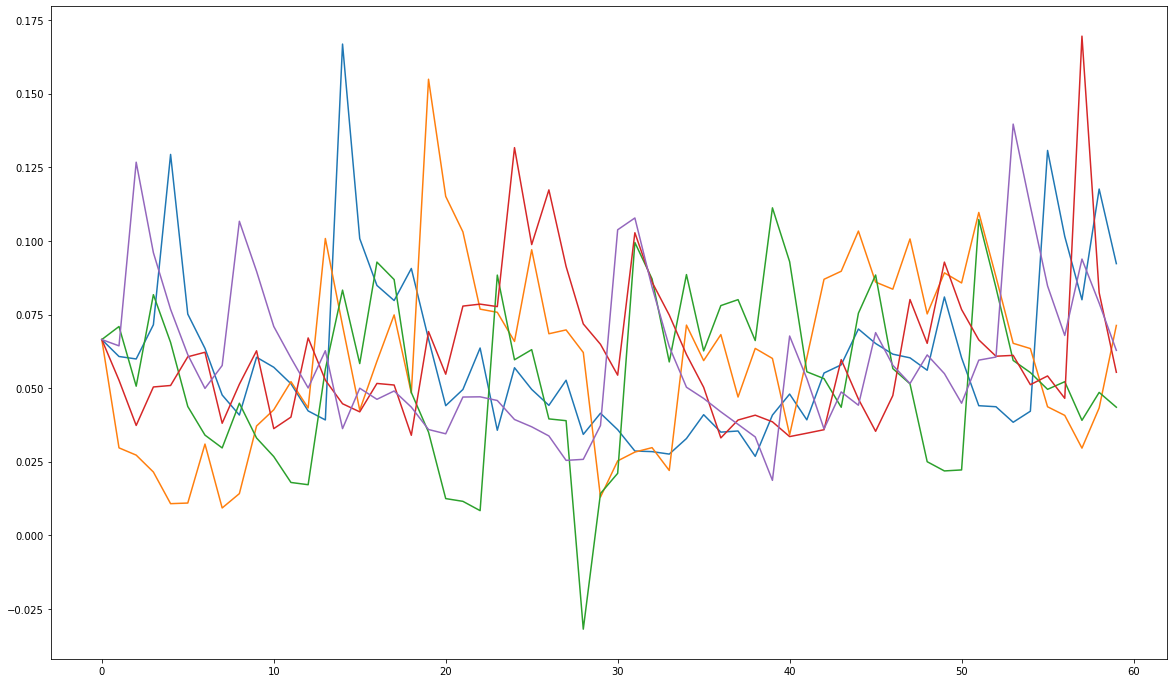

In [100]:
# Useful utility method for transposing lists of lists    
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.figure(figsize=(20,12))
plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))

In [101]:
bootstrap_predictions = pd.DataFrame(index = prev_data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap,pctl,axis=0)

bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions['actuals'] = y_test[-H:]

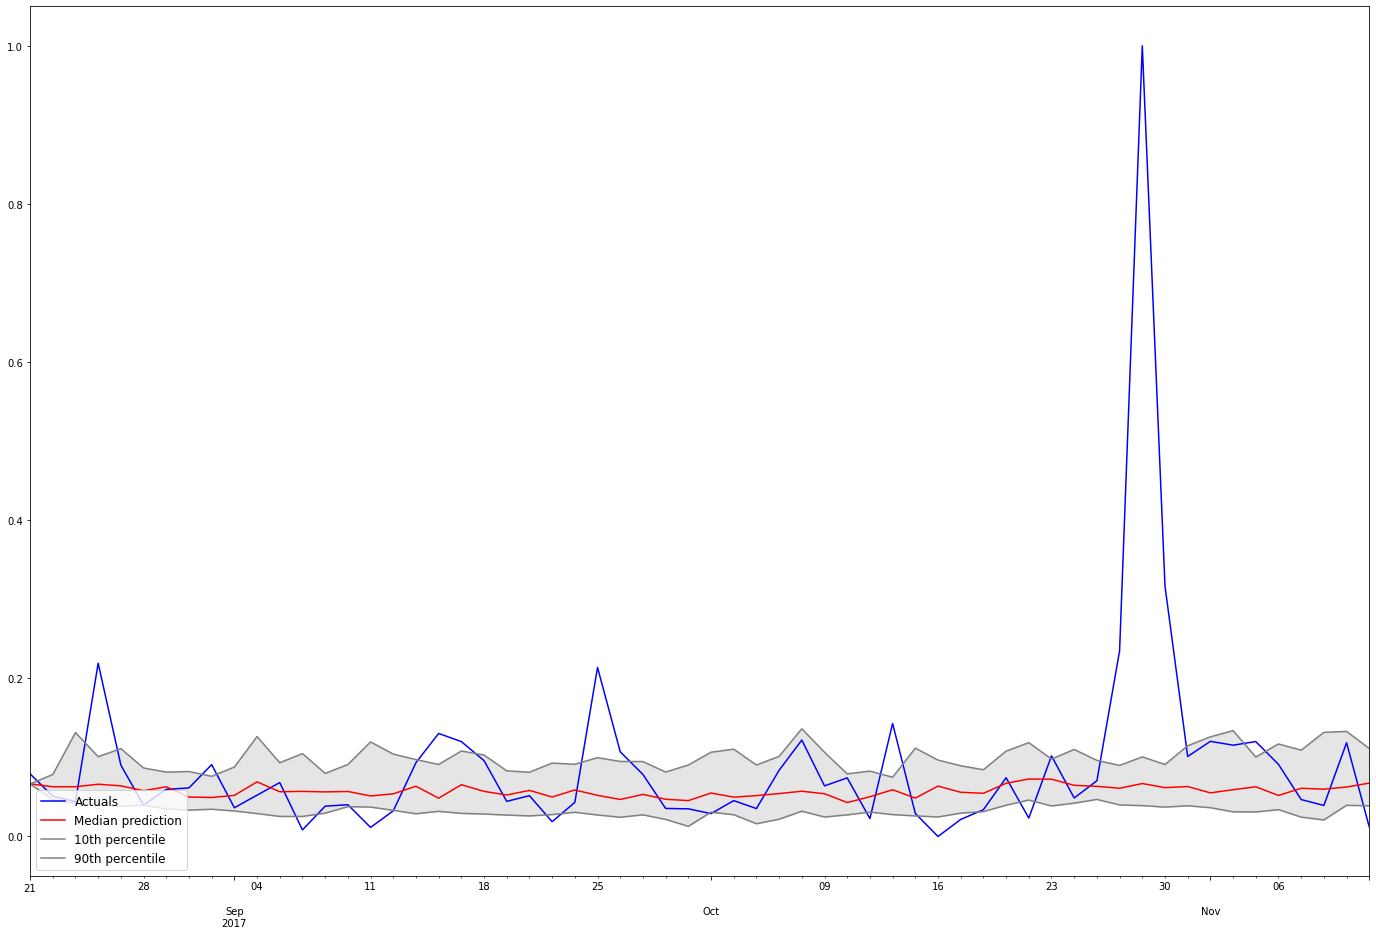

In [102]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots(figsize=(24,16))
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = prev_data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

# Task 6 - Model Evaluation
Evaluate the forecast performance of your model-based and pure forecasters using the test data and compare the two forecasters. Use appropriate evaluation metrics and methods. Discuss the similarities and difference between their performance and suggest possible avenues for improvement.

Mean absolute error for point forcasting and quartile scores for distributional forcast accuracy

In [135]:
from sklearn.metrics import mean_absolute_error, mean_pinball_loss
# import sklearn.metrics as skm

### Mean absolute error

In [116]:
test_amazon

2017-08-21     3157620.0
2017-08-22     2745802.0
2017-08-23     2644883.0
2017-08-24     5192822.0
2017-08-25     3318454.0
2017-08-28     2580401.0
2017-08-29     2871789.0
2017-08-30     2898148.0
2017-08-31     3327043.0
2017-09-01     2533975.0
2017-09-04     2765332.5
2017-09-05     2996690.0
2017-09-06     2125703.0
2017-09-07     2562567.0
2017-09-08     2589603.0
2017-09-11     2172012.0
2017-09-12     2476747.0
2017-09-13     3362218.0
2017-09-14     3900801.0
2017-09-15     3751327.0
2017-09-18     3400824.0
2017-09-19     2651065.0
2017-09-20     2755736.0
2017-09-21     2276738.0
2017-09-22     2632770.0
2017-09-25     5115458.0
2017-09-26     3562792.0
2017-09-27     3146172.0
2017-09-28     2521390.0
2017-09-29     2513654.0
2017-10-02     2425704.0
2017-10-03     2665119.0
2017-10-04     2518564.0
2017-10-05     3223573.0
2017-10-06     3779449.0
2017-10-09     2936290.0
2017-10-10     3083184.0
2017-10-11     2335171.0
2017-10-12     4083590.0
2017-10-13     2429486.0


For the following Mean absolute error comparison we need to scale the arima results down similar to what we have done for the nerual network results.

In [130]:
# Grab y pred and y test for arima model
arima_y_pred = pd.DataFrame(arima_predictions['trend+seasonal'])
arima_y_test = pd.DataFrame(test_amazon)

# Scale the arima pred and test values using MinMaxScaler

arima_y_pred_scaled = scaler.fit_transform(arima_y_pred.values.reshape(-1,1))
arima_y_test_scaled = scaler.fit_transform(arima_y_test.values.reshape(-1,1))

# arima_y_pred_scaled = [x for [x] in arima_y_pred_scaled]
# arima_y_test_scaled = [x for [x] in arima_y_test_scaled]

arima_mae = mean_absolute_error(arima_y_pred_scaled, arima_y_test_scaled)
nn_mae = mean_absolute_error(y_pred_multi, y_test_multi)

print(f"ARIMA MAE = {arima_mae}\nNeural Net MAE = {nn_mae}")

ARIMA MAE = 0.504881143102278
Neural Net MAE = 0.05828869550342611


In [132]:
arima_y_pred_scaled

[0.01646445237541716,
 0.600456273139744,
 1.0,
 0.7552823016003196,
 0.3440034219415309,
 0.00046711076756755787,
 0.5926107422528863,
 0.9961523385318953,
 0.7533953038959398,
 0.343077987007649,
 1.3252336865221537e-05,
 0.5923881577495593,
 0.9960431770450309,
 0.7533417681374468,
 0.3430517316174031,
 3.759802695846304e-07,
 0.5923818428345027,
 0.9960400800391445,
 0.7533402492816306,
 0.34305098672925194,
 1.066688604112187e-08,
 0.5923816636748955,
 0.9960399921744059,
 0.7533402061903764,
 0.34305096559613,
 3.0262903294442367e-10,
 0.5923816585919823,
 0.996039989681607,
 0.7533402049678397,
 0.3430509649965652,
 8.58557669403126e-12,
 0.5923816584477755,
 0.9960399896108845,
 0.7533402049331555,
 0.3430509649795548,
 2.438049762076844e-13,
 0.5923816584436841,
 0.9960399896088781,
 0.7533402049321714,
 0.34305096497907206,
 6.661338147750939e-15,
 0.5923816584435682,
 0.9960399896088212,
 0.7533402049321434,
 0.3430509649790583,
 0.0,
 0.592381658443565,
 0.9960399896088199,

### Interval Forcast Evaluation

In [155]:
results = {}
for alpha in [0.05, 0.5, 0.95]:
    metrics = {}
    metrics["ARIMA"] = mean_pinball_loss(arima_y_test_scaled, arima_y_pred_scaled, alpha=alpha)
    metrics["Neural Net"] = mean_pinball_loss(y_test_multi, y_pred_multi, alpha=alpha)
    results[alpha] = metrics

# for alpha, result in results.items():
#     print(f"Alpha {alpha}")
#     print(f"ARIMA == {result['ARIMA ' + str(alpha)]}")
#     print(f"Neural Net == {result['Neural Net ' + str(alpha)]}")
# #     print(f"ARIMA == {result}")

pd.DataFrame(results)

,0.05,0.50,0.95
ARIMA,0.453614,0.252441,0.051267
Neural Net,0.015523,0.029144,0.042765
